In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# 1) Load data
perf_df = pd.read_csv('account_performance.csv', index_col=0)  # InfoPool: 'Net Utility'
U_eps   = perf_df['Net Utility'].values

col_df  = pd.read_csv('collusive.csv', index_col=0)            # Collusive: 'u_col' (pre-fee)
u_col   = col_df['u_col'].values

with open('total_cost.txt') as f:
    C_tot = float(f.read().strip())                            # Total annual pooled cost

assert (perf_df.index == col_df.index).all()
N = len(U_eps)

# 2) Closed-form target-equal-dissatisfaction (with safe guards)
eps = 1e-12
U_safe = np.maximum(U_eps, eps)
a = 1.0 - (u_col / U_safe)
b = C_tot / U_safe

# If total cost ~ 0, just return uniform split (any split works)
if C_tot <= 1e-12:
    r_opt = np.ones(N) / N
else:
    # Unconstrained equalizer solution: d_j = a_j + b_j r_j all equal
    den = np.sum(1.0 / b)
    lam = (1.0 + np.sum(a / b)) / den
    r_star = (lam - a) / b

    # If feasible (>=0), use it; otherwise, fallback to SLSQP with nonnegativity
    if (r_star >= -1e-10).all():
        r_opt = np.clip(r_star, 0.0, None)
        r_opt /= r_opt.sum()
    else:
        def var_d(r):
            d = a + b * r
            m = d.mean()
            return np.mean((d - m)**2)

        x0 = np.ones(N) / N
        bounds = [(0, None)] * N
        cons   = ({'type': 'eq', 'fun': lambda r: np.sum(r) - 1},)
        res = minimize(var_d, x0, method='SLSQP', bounds=bounds, constraints=cons)
        r_opt = res.x

# 3) Compute final dissatisfaction and save
d_opt = a + b * r_opt

out_df = pd.DataFrame({
    'U_eps':           U_eps,
    'u_col':           u_col,
    'r_opt':           r_opt,
    'dissatisfaction': d_opt
}, index=perf_df.index)

out_df.to_csv('dissatisfaction_split.csv', float_format='%.6f')

# 4) Quick checks
print("✔ Saved dissatisfaction_split.csv")
print(f"[check] sum r = {r_opt.sum():.8f} ; min r = {r_opt.min():.6f} ; max r = {r_opt.max():.6f}")
print(f"[check] d range: max-min = {d_opt.max() - d_opt.min():.6e} ; mean(d) = {d_opt.mean():.6e}")


✔ Saved dissatisfaction_split.csv
[check] sum r = 1.00000000 ; min r = 0.018539 ; max r = 0.251814
[check] d range: max-min = 1.914763e-02 ; mean(d) = -3.912271e-02


==== Totals Check ====
Collusive cost used in split      : 66,935.30
Fair-split fee sum (should match) : 66,935.17
NASH: sum per-account cost (1x)   : 129,668.17
NASH: file total (often 0.5x)     : 64,834.08
==== KPI Summary (NE vs Fair) ====
                                         Value
Total_Collusive_PreFee            2.224645e+06
Total_Collusive_Cost              6.693530e+04
Total_Fair_Net                    2.157710e+06
Check_Fair_Total = PreFee - Cost  2.157710e+06
Total_NASH_PreFee                 2.222507e+06
Total_NASH_Cost_sum               1.296682e+05
Total_NASH_Net                    2.092839e+06
Fee_Gini_NASH                     1.813096e-01
Fee_Gini_Fair                     3.885488e-01
Fee_Theil_NASH                    5.648992e-02
Fee_Theil_Fair                    2.474070e-01
Diss_Gini_NASH                    2.307688e-01
Diss_Gini_Fair                    4.801464e-01
Diss_Theil_NASH                   2.302585e+00
Diss_Theil_Fair                   0.000000e+00
Diss_

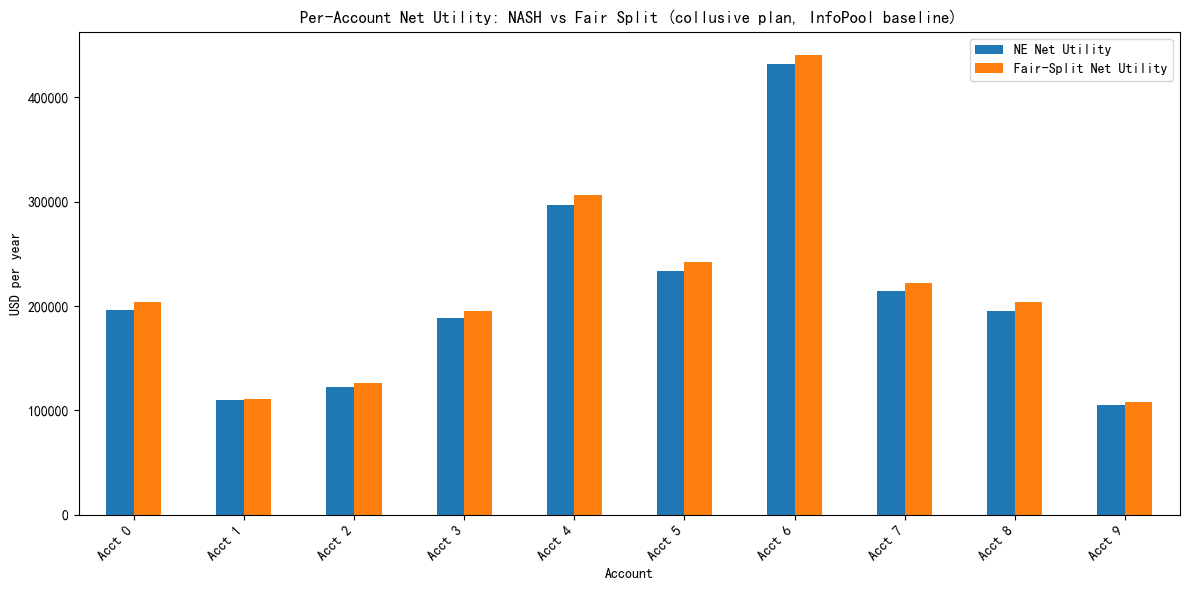

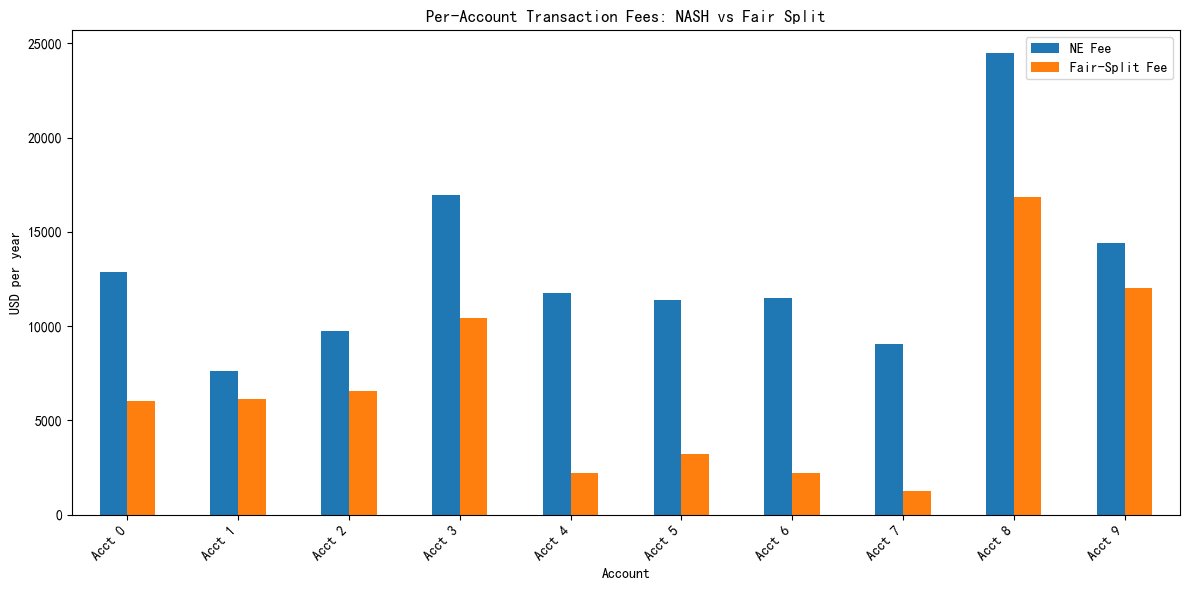

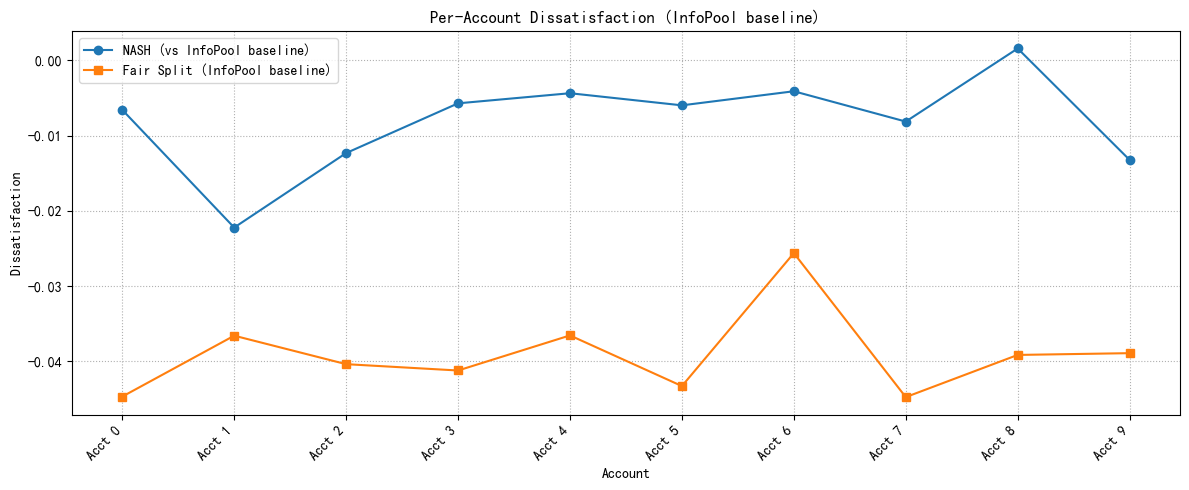

In [3]:
# ==== Visualization: Cournot–Nash vs Fair Split (InfoPool baseline + Collusive pre-fee) ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 0) Load data
perf_df  = pd.read_csv('account_performance.csv', index_col=0)   # InfoPool: 'Net Utility'
col_df   = pd.read_csv('collusive.csv', index_col=0)             # Collusive: 'u_col' (pre-fee)
split_df = pd.read_csv('dissatisfaction_split.csv', index_col=0) # r_opt, dissatisfaction
nash_df  = pd.read_csv('nash_components.csv', index_col=0)       # NASH: Revenue, RiskPenalty, ImpactCost(negative), Utility_NE

with open('total_cost.txt') as f:
    C_coll = float(f.read().strip())     # Collusive pooled cost (should match split_df usage)
with open('nash_total_cost.txt') as f:
    C_nash_file = float(f.read().strip())  # NASH pooled cost (for sanity prints)

# 1) Align by accounts
accounts = split_df.index.tolist()

def _align_like(df, tgt_idx):
    try:
        return df.loc[tgt_idx]
    except Exception:
        out = df.copy().iloc[:len(tgt_idx)].copy()
        out.index = tgt_idx
        return out

perf_df  = _align_like(perf_df,  accounts)
col_df   = _align_like(col_df,   accounts)
nash_df  = _align_like(nash_df,  accounts)

# 2) Vectors
U_eps   = perf_df['Net Utility'].values            # InfoPool baseline
u_col   = col_df['u_col'].values                   # Collusive pre-fee utility
r_opt   = split_df['r_opt'].values                 # Fair split weights
d_fair  = split_df['dissatisfaction'].values       # Fair split dissatisfaction (InfoPool-based)

fee_fair = r_opt * C_coll                          # Fair-split per-account fee (collusive plan)
net_fair = u_col - fee_fair                        # Net utility under Fair split

rev      = nash_df['Revenue'].values
risk_pen = nash_df['RiskPenalty'].values
cost_ne  = -nash_df['ImpactCost'].values           # positive per-account NASH cost
U_ne     = nash_df['Utility_NE'].values            # Net utility under NASH
u_pre_ne = rev + risk_pen                          # NASH pre-fee utility

# 3) Sanity checks
print("==== Totals Check ====")
print(f"Collusive cost used in split      : {C_coll:,.2f}")
print(f"Fair-split fee sum (should match) : {fee_fair.sum():,.2f}")
print(f"NASH: sum per-account cost (1x)   : {cost_ne.sum():,.2f}")
print(f"NASH: file total (often 0.5x)     : {C_nash_file:,.2f}")

# 4) Dissatisfaction for NASH, measured on the same InfoPool baseline (for apples-to-apples fairness comparison)
eps = 1e-12
U_safe = np.where(np.abs(U_eps) < eps, np.nan, U_eps)
d_ne = 1.0 - (U_ne / U_safe)   # if U_eps ≈ 0, becomes NaN and excluded by metrics below

# 5) Fairness metrics helpers
def _safe_array(x):
    x = np.asarray(x, dtype=float).ravel()
    return x[np.isfinite(x)]

def gini(x):
    x = _safe_array(x)
    if x.size == 0:
        return np.nan
    xmin = np.min(x)
    if xmin < 0:
        x = x - xmin           # translate so min>=0
    s = np.sum(x)
    if s <= 0:
        return 0.0
    xs = np.sort(x)
    n  = xs.size
    cumx = np.cumsum(xs)
    return float((n + 1 - 2.0 * np.sum(cumx) / cumx[-1]) / n)

def theil(x):
    x = _safe_array(x)
    x = np.maximum(x, 0.0)
    m = np.mean(x)
    if m <= 0:
        return 0.0
    z = np.where(x > 0, x, np.finfo(float).eps)
    return float(np.mean((z / m) * np.log(z / m)))

def lorenz_curve(x):
    x = _safe_array(x)
    x = np.maximum(x, 0.0)
    if x.size == 0 or np.sum(x) == 0:
        p = np.linspace(0, 1, 2)
        L = np.zeros_like(p)
        return p, L
    xs = np.sort(x)
    cumx = np.cumsum(xs)
    L = np.insert(cumx / cumx[-1], 0, 0.0)
    p = np.linspace(0, 1, L.size)
    return p, L

# 6) KPIs (saved to CSV)
kpis = {
    # Totals
    "Total_Collusive_PreFee": float(u_col.sum()),
    "Total_Collusive_Cost": float(C_coll),
    "Total_Fair_Net": float(net_fair.sum()),
    "Check_Fair_Total = PreFee - Cost": float(u_col.sum() - C_coll),

    "Total_NASH_PreFee": float(u_pre_ne.sum()),
    "Total_NASH_Cost_sum": float(cost_ne.sum()),
    "Total_NASH_Net": float(U_ne.sum()),

    # Fee fairness
    "Fee_Gini_NASH": gini(cost_ne),
    "Fee_Gini_Fair": gini(fee_fair),
    "Fee_Theil_NASH": theil(cost_ne),
    "Fee_Theil_Fair": theil(fee_fair),

    # Dissatisfaction fairness (all on InfoPool baseline)
    "Diss_Gini_NASH": gini(d_ne),
    "Diss_Gini_Fair": gini(d_fair),
    "Diss_Theil_NASH": theil(np.maximum(d_ne, 0)),
    "Diss_Theil_Fair": theil(np.maximum(d_fair, 0)),
    "Diss_Std_NASH": float(np.nanstd(d_ne)),
    "Diss_Std_Fair": float(np.nanstd(d_fair)),
    "Diss_MaxMinusMin_NASH": float(np.nanmax(d_ne) - np.nanmin(d_ne)),
    "Diss_MaxMinusMin_Fair": float(np.nanmax(d_fair) - np.nanmin(d_fair)),
}
kpis_df = pd.DataFrame.from_dict(kpis, orient='index', columns=['Value'])
kpis_df.to_csv('viz_kpis_ne_vs_fair.csv', float_format='%.6f')
print("==== KPI Summary (NE vs Fair) ====")
print(kpis_df)

# Also export a per-account comparison table
compare_df = pd.DataFrame({
    "InfoPool_Baseline": U_eps,
    "Collusive_PreFee": u_col,
    "Fair_Fee": fee_fair,
    "Fair_Net": net_fair,
    "Fair_Dissatisfaction": d_fair,
    "NASH_PreFee": u_pre_ne,
    "NASH_Fee": cost_ne,
    "NASH_Net": U_ne,
    "NASH_Dissatisfaction": d_ne
}, index=accounts)
compare_df.to_csv('viz_compare_ne_vs_fair_en.csv', float_format='%.6f')

# 7) Plots (pure matplotlib; one figure per chart; no seaborn)
# (A) Net utility per account: NASH vs Fair split (collusive plan)
fig, ax = plt.subplots(figsize=(max(12, 0.7 * len(accounts)), 6))
pd.DataFrame({
    'NE Net Utility': U_ne,
    'Fair-Split Net Utility': net_fair
}, index=accounts).plot.bar(ax=ax)
ax.set_title('Per-Account Net Utility: NASH vs Fair Split (collusive plan, InfoPool baseline)')
ax.set_ylabel('USD per year')
ax.set_xlabel('Account')
ax.legend()
plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()

# (B) Transaction fees per account: NASH vs Fair split
fig, ax = plt.subplots(figsize=(max(12, 0.7 * len(accounts)), 6))
pd.DataFrame({
    'NE Fee': cost_ne,
    'Fair-Split Fee': fee_fair
}, index=accounts).plot.bar(ax=ax)
ax.set_title('Per-Account Transaction Fees: NASH vs Fair Split')
ax.set_ylabel('USD per year')
ax.set_xlabel('Account')
ax.legend()
plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()

# (C) Dissatisfaction per account (lower dispersion = fairer), measured on InfoPool baseline
fig, ax = plt.subplots(figsize=(max(12, 0.7 * len(accounts)), 5))
ax.plot(accounts, d_ne, marker='o', label='NASH (vs InfoPool baseline)')
ax.plot(accounts, d_fair, marker='s', label='Fair Split (InfoPool baseline)')
ax.set_title('Per-Account Dissatisfaction (InfoPool baseline)')
ax.set_ylabel('Dissatisfaction')
ax.set_xlabel('Account')
ax.grid(True, linestyle=':')
ax.legend()
plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()


